  # Test of hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight

  ### Definition of names for plots and files

In [2]:

date = '20200609'

#names of files with features and labels for the training set (v7)
labels_file = '../../alerce_trainingset/training_set_v7/dfcrossmatches_prioritized_v7.0.3.csv'

features_path = '/Users/psanchez/Documents/Postdoc/Alerce/new_DB/features/'

features_file = features_path+'features_for_ML_with_WISE.parquet'

#features_file = '../ZTF_data/features_20200109_phot_corrected_withWISE_withSNfeat_withMHPScorrected.csv'

class_output = '../../ZTF_classifications/classes_BHRF_TSv7.0.3_original_hierarchical_classes_'+date+'.csv'

#where the RF models are saved

model_first_layer = 'final_BHRF_model/hierarchical_level_RF_model.pkl'
model_periodic_layer = 'final_BHRF_model/periodic_level_RF_model.pkl'
model_transient_layer = 'final_BHRF_model/stockastic_level_RF_model.pkl'
model_stochastic_layer = 'final_BHRF_model/transient_level_RF_model.pkl'

features_pickle = 'final_BHRF_model/features_RF_model.pkl'    
    
#confusion matrixes

conf_matrix_name_first_layer = 'plots/confusion_matrix_rf_model_2_hierarchical_layer_'+date
conf_matrix_name_second_layer = 'plots/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances

feature_importance_name_first_layer = 'plots/feature_importance_rf_model_2_hierarchical_layer_'+date+'.pdf'
feature_importance_name_periodic_layer = 'plots/feature_importance_rf_model_2_periodic_layer_'+date+'.pdf'
feature_importance_name_transient_layer = 'plots/feature_importance_rf_model_2_transient_layer_'+date+'.pdf'
feature_importance_name_stochastic_layer = 'plots/feature_importance_rf_model_2_stochastic_layer_'+date+'.pdf'

### reading the training set files 

In [3]:
df_feat = pd.read_parquet(features_file)
#df_feat.set_index('oid',inplace=True)
#df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)
print(df_feat.head())

149879
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['classALeRCE'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'E' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'E'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper

#df_labels = df_labels[(df_labels['source']!="ASASSN") & (df_labels['source']!="GAIADR2VS")]
#df_labels = df_labels[(df_labels['source']!="ASASSN") ]

df_labels = df_labels[(df_labels['class_source']!="ELL")]


bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']

df_labels.drop(bad_oid,inplace=True)


#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(149041,)


,class_original,class_hierachical
oid,,
ZTF19abdbtlb,Blazar,Stochastic
ZTF19abdktzn,Blazar,Stochastic
ZTF18acxhtzv,Blazar,Stochastic
ZTF19abjpqvm,Blazar,Stochastic
ZTF18acafkde,Blazar,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
#'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro',
#'w1mag', 'w2mag' ,'w3mag','w4mag',
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
#'g-r_max_corr',
#'g-r_mean_corr',
#'g-r_mean',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
#print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
#print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

#print(df['g-r_max'].values.size)
df.head()

107776


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18acxhtzv,0.297294,0.070918,0.999669,0.878954,1.0,1.0,0.166667,0.428571,0.0,0.0,...,0.870000,1.000000,0.850,2.426,8.151376,5.725376,8.223164,5.797164,0.086881,1.461400
ZTF18abtphro,0.274613,-999.000000,0.986429,-999.000000,2.0,-999.0,0.375000,-999.000000,0.0,-999.0,...,0.831667,0.986687,1.228,3.321,-999.000000,-999.000000,7.658440,4.337440,0.009855,-999.000000
ZTF18acejbcb,0.110290,0.060682,0.609409,0.712830,1.0,1.0,0.375000,0.200000,0.0,0.0,...,0.923572,0.024417,0.340,1.970,6.387238,4.417238,7.277533,5.307533,0.030629,0.000001
ZTF18acskqvq,0.088963,-999.000000,0.536479,-999.000000,1.0,-999.0,0.333333,-999.000000,0.0,-999.0,...,0.848571,0.992000,1.311,2.877,-999.000000,-999.000000,8.072067,5.195067,0.043885,-999.000000
ZTF18acujppo,0.128972,-999.000000,0.470641,-999.000000,2.0,-999.0,0.250000,-999.000000,0.0,-999.0,...,0.782857,0.972083,1.174,3.587,-999.000000,-999.000000,9.900870,6.313870,0.058970,-999.000000


In [6]:
#print(df.columns)
print(np.array(df.columns))
print(len(np.array(df.columns)))

['Amplitude_1' 'Amplitude_2' 'AndersonDarling_1' 'AndersonDarling_2'
 'Autocor_length_1' 'Autocor_length_2' 'Beyond1Std_1' 'Beyond1Std_2'
 'Con_1' 'Con_2' 'Eta_e_1' 'Eta_e_2' 'ExcessVar_1' 'ExcessVar_2'
 'GP_DRW_sigma_1' 'GP_DRW_sigma_2' 'GP_DRW_tau_1' 'GP_DRW_tau_2' 'Gskew_1'
 'Gskew_2' 'Harmonics_mag_1_1' 'Harmonics_mag_1_2' 'Harmonics_mag_2_1'
 'Harmonics_mag_2_2' 'Harmonics_mag_3_1' 'Harmonics_mag_3_2'
 'Harmonics_mag_4_1' 'Harmonics_mag_4_2' 'Harmonics_mag_5_1'
 'Harmonics_mag_5_2' 'Harmonics_mag_6_1' 'Harmonics_mag_6_2'
 'Harmonics_mag_7_1' 'Harmonics_mag_7_2' 'Harmonics_mse_1'
 'Harmonics_mse_2' 'Harmonics_phase_2_1' 'Harmonics_phase_2_2'
 'Harmonics_phase_3_1' 'Harmonics_phase_3_2' 'Harmonics_phase_4_1'
 'Harmonics_phase_4_2' 'Harmonics_phase_5_1' 'Harmonics_phase_5_2'
 'Harmonics_phase_6_1' 'Harmonics_phase_6_2' 'Harmonics_phase_7_1'
 'Harmonics_phase_7_2' 'IAR_phi_1' 'IAR_phi_2' 'LinearTrend_1'
 'LinearTrend_2' 'MHPS_high_1' 'MHPS_high_2' 'MHPS_low_1' 'MHPS_low_2'
 'MHPS_rati

In [7]:
for idx, cl in enumerate(label_order):
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1272
SNIbc 94
SNII 328
SLSN 24
QSO 13617
AGN 1498
Blazar 1267
YSO 1740
CV/Nova 871
LPV 14076
E 37901
DSCT 732
RRL 32482
CEP 618
Periodic-Other 1256


Counter({'E': 37901, 'RRL': 32482, 'LPV': 14076, 'QSO': 13617, 'YSO': 1740, 'AGN': 1498, 'SNIa': 1272, 'Blazar': 1267, 'Periodic-Other': 1256, 'CV/Nova': 871, 'DSCT': 732, 'CEP': 618, 'SNII': 328, 'SNIbc': 94, 'SLSN': 24})
                number
E                37901
RRL              32482
LPV              14076
QSO              13617
YSO               1740
AGN               1498
SNIa              1272
Blazar            1267
Periodic-Other    1256
CV/Nova            871
DSCT               732
CEP                618
SNII               328
SNIbc               94
SLSN                24


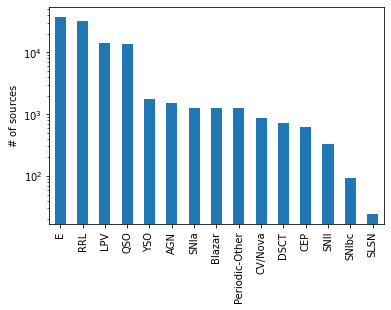

In [8]:
class_counts = Counter(labels['class_original'])
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)


plt.yscale('log')
#plt.title('sources classified')
plt.ylabel(r'$\#$ of sources')

plt.savefig('plots/number_sources_labeled_set.pdf',bbox_inches='tight')

  ### Defining functions to plot the confusion matrix and the feature importance

In [9]:
'''def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()'''
    
    
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    
    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    


def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name, bbox_inches='tight')
    #plt.close()

### Pre-processing training data

In [10]:
Y_hierarchical = labels['class_hierachical']
Y_original = labels['class_original']

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
          Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

X_test_periodic = X_test_hierarchical
X_test_stochastic = X_test_hierarchical
X_test_transient = X_test_hierarchical

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

107776
107776
69652 15194 1374


In [11]:
print(X_train_hierarchical.index)
print(X_test_hierarchical.index)

np.save('final_BHRF_model/labels_training_sample', X_train_hierarchical.index.values)
np.save('final_BHRF_model/labels_testint_sample', X_test_hierarchical.index.values)

Index(['ZTF18ablwqqj', 'ZTF18aaaahny', 'ZTF18abstbaj', 'ZTF18aaxybbb',
       'ZTF19aadflra', 'ZTF18acyghtz', 'ZTF17aaaivzt', 'ZTF19acmbndn',
       'ZTF18abvzlam', 'ZTF18abdroaj',
       ...
       'ZTF20aammicx', 'ZTF18abbrnya', 'ZTF18aaabiby', 'ZTF18aajlvsx',
       'ZTF20aavdabj', 'ZTF18abuetqy', 'ZTF18abuaeeu', 'ZTF17aaaanxe',
       'ZTF19aawnmqv', 'ZTF17aacnjmv'],
      dtype='object', name='oid', length=86220)
Index(['ZTF18abilngs', 'ZTF18abnjutc', 'ZTF19acqdgij', 'ZTF18aaakmwt',
       'ZTF18abxigdd', 'ZTF18abdlbdh', 'ZTF17aaadpbp', 'ZTF18abfxvbh',
       'ZTF18acrunah', 'ZTF18abcuefx',
       ...
       'ZTF18acgukxz', 'ZTF19aazrkqe', 'ZTF18acesgpw', 'ZTF19aaaoogh',
       'ZTF18aaxdczb', 'ZTF18aauqjtm', 'ZTF18abdettz', 'ZTF18abvwdss',
       'ZTF17aaaeiex', 'ZTF18acnbngd'],
      dtype='object', name='oid', length=21556)


  ## Balanced random forest
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [12]:
#Training first layer of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)


rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first layer performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)


print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)
        
with open(model_first_layer, 'wb') as f:
            pickle.dump(
                rf_model_hierarchical,
                f,
                pickle.HIGHEST_PROTOCOL)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9844590833178697
Balanced accuracy: 0.9788487971505644


[[  343     0     1]
 [   28  3598   173]
 [   14   119 17280]]
Normalized confusion matrix
[[100.   0.   0.]
 [  1.  95.   5.]
 [  0.   1.  99.]]


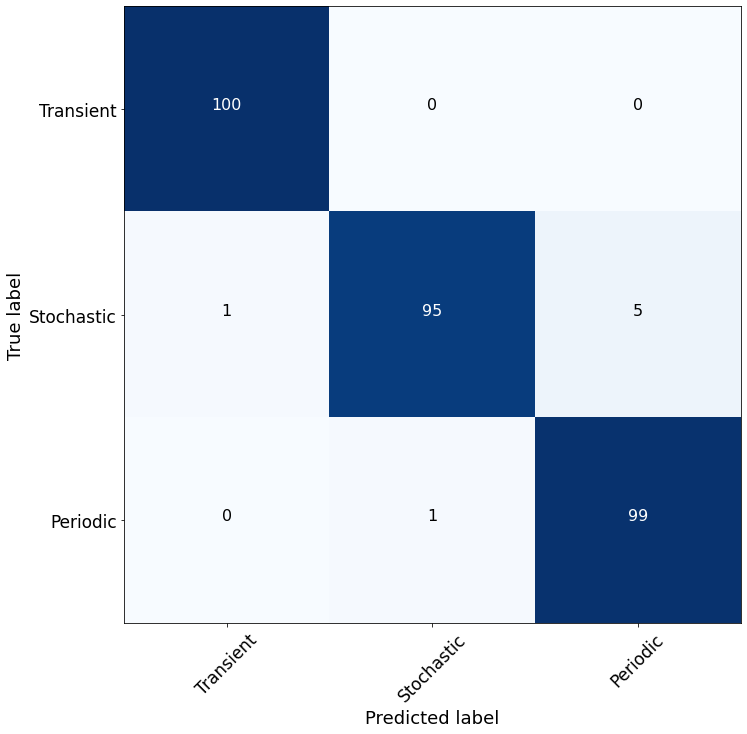

In [13]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,'plots/training_conf_matrix_hierarchical_level.pdf')

W1-W2 & 0.089
sgscore1 & 0.064
positive_fraction_1 & 0.052
positive_fraction_2 & 0.051
SPM_beta_1 & 0.038
SPM_tau_rise_1 & 0.033
SPM_chi_1 & 0.028
n_non_det_after_fid_2 & 0.026
g-W3 & 0.025
LinearTrend_2 & 0.024
g-W2 & 0.023
W2-W3 & 0.020
LinearTrend_1 & 0.019
SPM_A_1 & 0.018
SPM_A_2 & 0.018
SPM_chi_2 & 0.018
ExcessVar_1 & 0.017
SPM_tau_rise_2 & 0.015
SPM_tau_fall_1 & 0.015
r-W3 & 0.014
Rcs_2 & 0.013
ExcessVar_2 & 0.013
r-W2 & 0.013
Pvar_1 & 0.012
Meanvariance_1 & 0.010
MHPS_low_2 & 0.010
SPM_t0_1 & 0.010
GP_DRW_sigma_2 & 0.009
Meanvariance_2 & 0.009
SPM_tau_fall_2 & 0.009


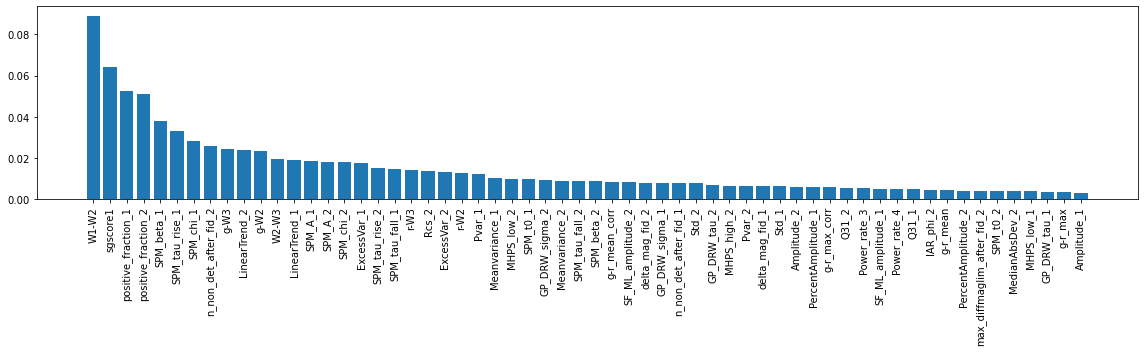

In [14]:
#plotting feature importance
plot_feature_importances(rf_model_hierarchical, features_hierarchical, 'final_BHRF_model/feature_ranking_hierarchical_level.pdf')

  ### Periodic layer

In [15]:
#Training Periodic layer

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)


# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as f:
            pickle.dump(
                rf_model_periodic,
                f,
                pickle.HIGHEST_PROTOCOL)

['CEP' 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


67
Multiband_period & 0.092
g-W2 & 0.058
g-r_max_corr & 0.032
r-W2 & 0.032
g-W3 & 0.031
g-r_mean & 0.028
g-r_max & 0.027
g-r_mean_corr & 0.024
IAR_phi_1 & 0.021
GP_DRW_tau_1 & 0.020
Amplitude_1 & 0.018
ExcessVar_1 & 0.018
Meanvariance_1 & 0.017
GP_DRW_sigma_1 & 0.014
delta_mag_fid_1 & 0.014
r-W3 & 0.014
Std_1 & 0.013
PercentAmplitude_1 & 0.012
GP_DRW_tau_2 & 0.012
Autocor_length_1 & 0.011
W1-W2 & 0.009
SPM_A_1 & 0.009
SF_ML_amplitude_1 & 0.009
Gskew_1 & 0.008
W2-W3 & 0.008
delta_mag_fid_2 & 0.008
SF_ML_gamma_1 & 0.007
Q31_1 & 0.007
Amplitude_2 & 0.007
IAR_phi_2 & 0.007


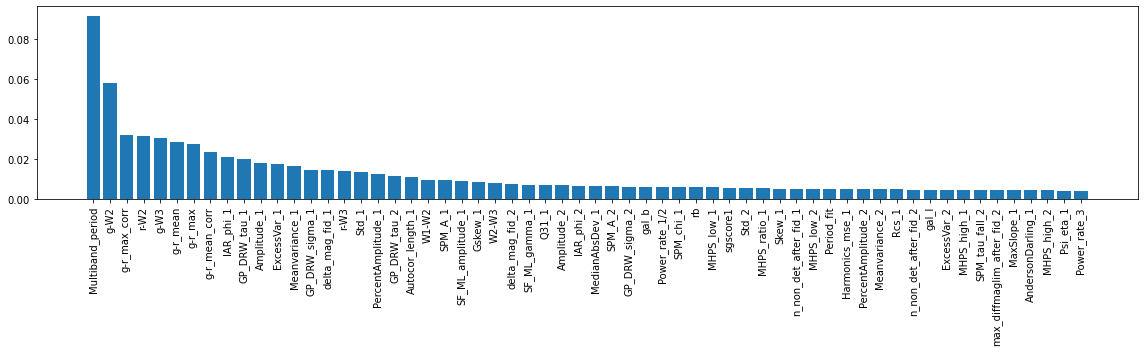

In [16]:
#plotting feature importance
print(len(feature_importance_name_first_layer))
plot_feature_importances(rf_model_periodic, features_periodic, 'final_BHRF_model/feature_ranking_periodic_level.pdf')

  ### Stochastic layer

In [17]:
#Training Stochastic layer

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)


# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)


with open(model_stochastic_layer, 'wb') as f:
            pickle.dump(
                rf_model_stochastic,
                f,
                pickle.HIGHEST_PROTOCOL)

['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO']


W1-W2 & 0.124
sgscore1 & 0.098
gal_b & 0.080
g-r_mean_corr & 0.048
r-W2 & 0.047
g-W2 & 0.036
g-r_max_corr & 0.033
g-W3 & 0.030
delta_mag_fid_2 & 0.028
Meanvariance_2 & 0.027
ExcessVar_2 & 0.025
r-W3 & 0.024
W2-W3 & 0.023
g-r_mean & 0.022
Amplitude_2 & 0.019
Std_2 & 0.018
SPM_A_2 & 0.013
GP_DRW_sigma_2 & 0.013
PercentAmplitude_2 & 0.012
g-r_max & 0.012
SPM_A_1 & 0.011
IAR_phi_1 & 0.009
ExcessVar_1 & 0.008
delta_mag_fid_1 & 0.007
Pvar_2 & 0.006
MHPS_low_1 & 0.006
MedianAbsDev_2 & 0.006
IAR_phi_2 & 0.005
GP_DRW_tau_2 & 0.005
Std_1 & 0.005


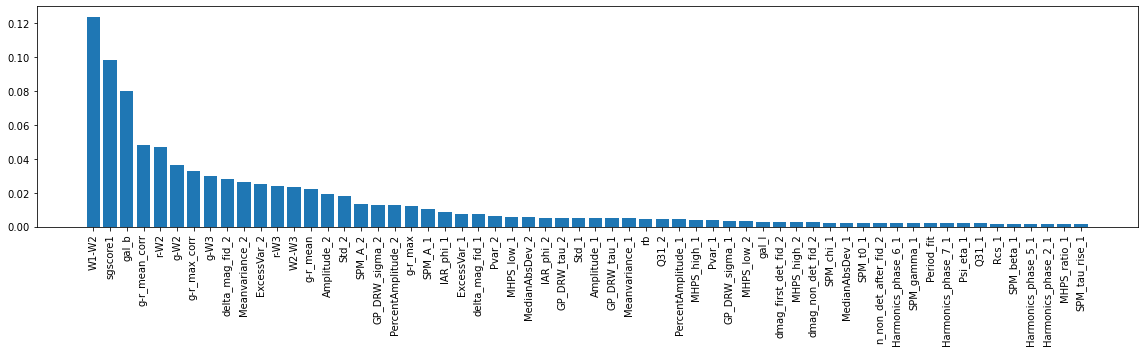

In [18]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, 'final_BHRF_model/feature_ranking_stochastic_level.pdf')


  ### Transient layer

In [19]:
#Training Transient layer

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as f:
            pickle.dump(
                rf_model_transient,
                f,
                pickle.HIGHEST_PROTOCOL)
        
with open(features_pickle, 'wb') as f:
            pickle.dump(
                features_transient,
                f,
                pickle.HIGHEST_PROTOCOL)

['SLSN' 'SNII' 'SNIa' 'SNIbc']


SPM_beta_2 & 0.038
SPM_t0_1 & 0.031
LinearTrend_2 & 0.026
SPM_t0_2 & 0.024
SPM_tau_rise_2 & 0.024
MHPS_ratio_1 & 0.022
g-r_max & 0.022
MHPS_low_1 & 0.019
SPM_beta_1 & 0.015
SPM_tau_rise_1 & 0.015
g-r_mean & 0.015
MHPS_low_2 & 0.013
LinearTrend_1 & 0.013
SPM_A_2 & 0.013
dmag_first_det_fid_1 & 0.012
AndersonDarling_2 & 0.012
sgscore1 & 0.011
SPM_tau_fall_2 & 0.011
SPM_tau_fall_1 & 0.010
GP_DRW_tau_1 & 0.010
SF_ML_amplitude_1 & 0.009
MedianAbsDev_2 & 0.008
Period_fit & 0.008
last_diffmaglim_before_fid_2 & 0.008
MHPS_ratio_2 & 0.008
SPM_gamma_1 & 0.008
Harmonics_phase_3_2 & 0.008
Psi_CS_2 & 0.007
Harmonics_phase_7_1 & 0.007
Skew_2 & 0.007


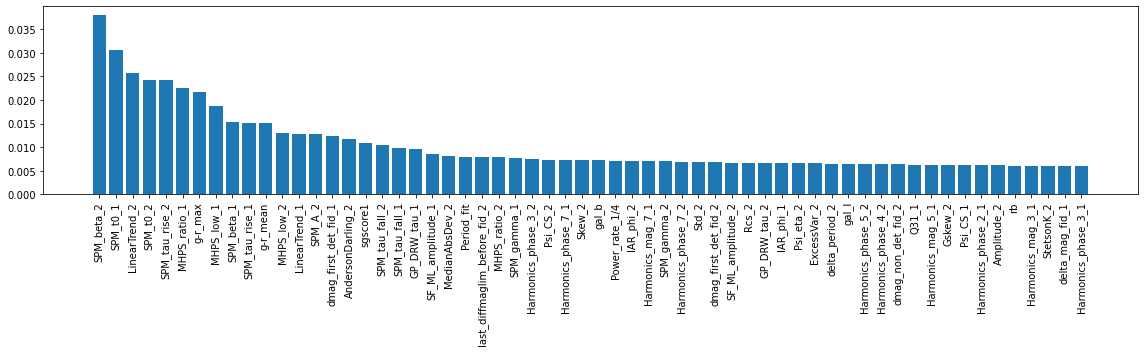

In [20]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, 'final_BHRF_model/feature_ranking_transient_level.pdf')



 ## Putting al layers together  


In [21]:
# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]



[1. 1. 1. ... 1. 1. 1.] 1.0 7.65724951304442e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


[[ 198   45    7    3    0    0    0    0    0    0    0    0    0    0
     1]
 [   5   13    0    1    0    0    0    0    0    0    0    0    0    0
     0]
 [  12    9   35   10    0    0    0    0    0    0    0    0    0    0
     0]
 [   1    0    0    4    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0    0    0 2583   34  100    2    5    0    0    0    0    0
     0]
 [   0    0    0    2   11  273   13    0    1    0    0    0    0    0
     0]
 [   1    0    0    0   36   19  187    4    3    1    0    0    1    0
     1]
 [   0    0    0    0    0    0    2  278    2   10    2    1    3   14
    36]
 [  11    2    2    0    1    0    3    0  121    0    4    6   14    4
     6]
 [   0    1    0    0    0    0    2   72    2 2708    0    0    0   18
    12]
 [   0    0    0    0    9    0    5   58   96    4 5506  478  247  278
   899]
 [   0    0    0    0    0    0    0    0    0    0    4  134    1    1
     6]
 [   0    0    0    0   11    0    1   3

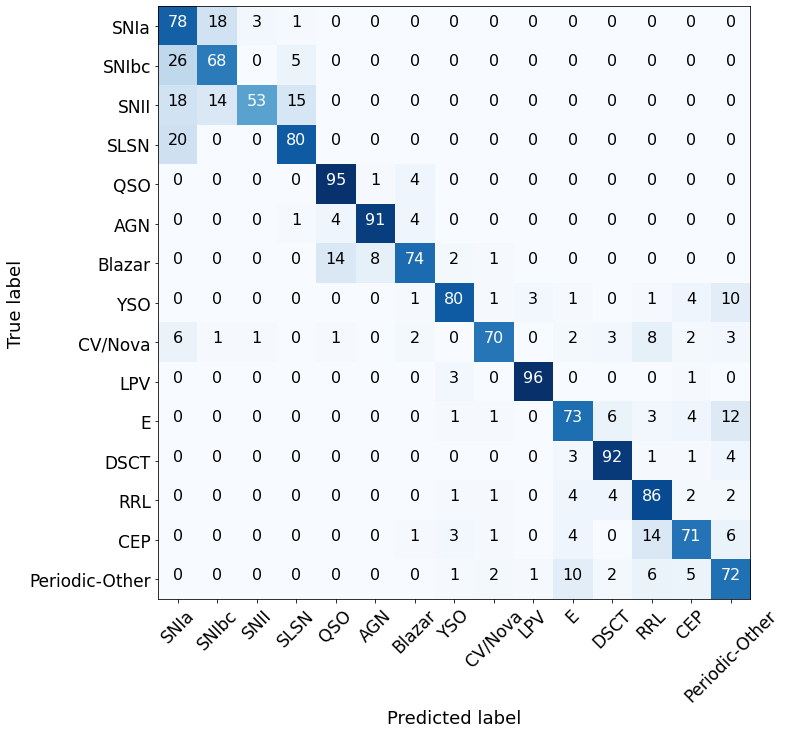

In [22]:
# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, 'plots/conf_matrix_multiclass_level.pdf')

print("Accuracy:", "%0.2f" % metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:","%0.2f" %  metrics.balanced_accuracy_score(y_test_original, class_final_name))

print("macro precision: ","%0.2f" %  metrics.precision_score(y_test_original, class_final_name, average='macro'))
print("macro recall: ","%0.2f" %  metrics.recall_score(y_test_original, class_final_name, average='macro'))
print("macro F1: ","%0.2f" %  metrics.f1_score(y_test_original, class_final_name, average='macro'))

print(metrics.classification_report(y_test_original, class_final_name, digits=2))

In [23]:
# Kaggle score

num_y_test =  class_final_index
class_weights = list(class_weight.compute_class_weight('balanced', label_order, y_test_original))

print(class_weights)

CLASSES_REDUCED_V2 = label_order

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final))

[5.657742782152231, 75.63508771929824, 21.773737373737372, 287.41333333333336, 0.5275575134605972, 4.790222222222222, 5.680105401844532, 4.129501915708812, 8.259003831417624, 0.5105032563647128, 0.18958663148636765, 9.842922374429223, 0.22118926684110615, 11.589247311827958, 5.725365205843294]
SNIa -0.02319243108550401
SNIbc -0.03962321428255898
SNII -0.06770857015666246
SLSN -0.01750288405741286
QSO -0.05341583653351664
AGN -0.07134378279290775
Blazar -0.07160855085306815
YSO -0.06684779342060711
CV/Nova -0.07193074407437589
LPV -0.060538664806517394
E -0.06299885749330697
DSCT -0.04448139172675564
RRL -0.021807205838600678
CEP -0.062385598568286744
Periodic-Other -0.03353281770818446
0.7689183433982658


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=['SNIa', 'SNIbc', 'SNII', 'SLSN', 'QSO', 'AGN', 'Blazar', 'YSO', 'CV/Nova', 'LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other'], y=oid
ZTF18abilngs          E
ZTF18abnjutc        CEP
ZTF19acqdgij        QSO
ZTF18aaakmwt          E
ZTF18abxigdd          E
ZTF18abdlbdh        LPV
ZTF17aaadpbp          E
ZTF18abfxvbh        LPV
ZTF18acrunah        YSO
ZTF18abcuefx          E
ZTF18abcppir          E
ZTF18abtvsjy          E
ZTF19adccmrr        QSO
ZTF18acdvwug          E
ZTF18acurivs        RRL
ZTF18aazhegx        QSO
ZTF18abbuvvl          E
ZTF19aasezfy        QSO
ZTF18aaudygf        LPV
ZTF18aaluqql          E
ZTF18abddrao          E
ZTF18aaiyxlx          E
ZTF18abdihhi        LPV
ZTF18abhxogq        LPV
ZTF18acvvpsx          E
ZTF18acwzarj          E
ZTF18achuiqk          E
ZTF18acvbkyl          E
ZTF18aahwtrz        QSO
ZTF19aanonjt       SNIa
                 ...   
ZTF17aaawgat      

  ## Classifying unlabeled data

In [24]:
#loading the data
print(rm_nd_cols)

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

df_feat_ul_out = df_feat_ul

df_feat_ul.head()

['n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'first_mag_1', 'first_mag_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2', 'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'mean_mag_1', 'mean_mag_2', 'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'iqr_1', 'iqr_2', 'delta_mjd_fid_1', 'delta_mjd_fid_2', 'last_mjd_before_fid_1', 'last_mjd_before_fid_2', 'g-r_ml', 'MHAOV_Period_1', 'MHAOV_Period_2']


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaavn,0.078912,0.097860,0.847902,0.673712,2.0,1.0,0.380952,0.428571,0.0,0.0,...,0.738809,0.989375,-0.301,1.491,4.239709,2.748709,5.350475,3.859475,0.017990,4.895612e-01
ZTF17aaaadjh,0.493980,0.463765,1.000000,1.000000,1.0,1.0,0.279070,0.293103,0.0,0.0,...,0.742857,1.000000,-0.125,2.380,4.533904,2.153904,5.281445,2.901445,0.000011,5.197596e-08
ZTF17aaaadwo,0.090708,0.196542,0.903625,0.993806,1.0,1.0,0.368421,0.285714,0.0,0.0,...,0.737143,0.992667,-0.065,1.602,4.344352,2.742352,5.495974,3.893974,0.423044,2.662193e-01
ZTF17aaaajjv,0.539600,0.566276,1.000000,1.000000,14.0,20.0,0.419580,0.481203,0.0,0.0,...,0.743333,1.000000,-0.040,0.997,7.765696,6.768696,10.193531,9.196531,29.239637,1.437226e-04
ZTF17aaaakjt,0.564867,0.572449,0.999907,0.990501,1.0,1.0,0.338462,0.350000,0.0,0.0,...,0.818571,0.975000,-0.027,0.027,3.161238,3.134238,4.298826,4.271826,0.000002,2.169809e-06


In [25]:
#predicting classes of unlabeled data

test_Y_hierarchical = rf_model_hierarchical.predict(df_feat_ul)
test_Y_proba_hierarchical = rf_model_hierarchical.predict_proba(df_feat_ul)

test_Y_periodic = rf_model_periodic.predict(df_feat_ul)
test_Y_proba_periodic = rf_model_periodic.predict_proba(df_feat_ul)

test_Y_stochastic = rf_model_stochastic.predict(df_feat_ul)
test_Y_proba_stochastic = rf_model_stochastic.predict_proba(df_feat_ul)

test_Y_transient = rf_model_transient.predict(df_feat_ul)
test_Y_proba_transient = rf_model_transient.predict_proba(df_feat_ul)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]


[1. 1. 1. ... 1. 1. 1.] 1.0 8.893375616573264e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


In [26]:
#Writing results in the output
df_out = df_feat
print(df_out.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


df_out['predicted_class'] = class_final_name_ul
df_out['predicted_class_proba'] = class_final_proba_ul
test_data_withclass = df_out


probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

#test_data_withclass.to_csv(class_output)

test_data_withclass.head()


(868371, 183)
868371
868371


,MHAOV_Period_1,MHAOV_Period_2,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,...,SNIbc_prob,CEP_prob,DSCT_prob,E_prob,LPV_prob,Periodic-Other_prob,RRL_prob,prob_Periodic,prob_Stochastic,prob_Transient
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaavn,0.106021,0.613572,0.078912,0.097860,0.847902,0.673712,2.0,1.0,0.380952,0.428571,...,0.001212,0.045144,0.020196,0.125928,0.019008,0.367092,0.016632,0.594,0.400,0.006
ZTF17aaaadjh,0.233443,0.233454,0.493980,0.463765,1.000000,1.000000,1.0,1.0,0.279070,0.293103,...,0.000000,0.096432,0.027552,0.623856,0.000000,0.068880,0.167280,0.984,0.016,0.000
ZTF17aaaadwo,0.060049,0.216873,0.090708,0.196542,0.903625,0.993806,1.0,1.0,0.368421,0.285714,...,0.000000,0.079772,0.034188,0.223036,0.009768,0.434676,0.032560,0.814,0.186,0.000
ZTF17aaaajjv,526.315748,555.555529,0.539600,0.566276,1.000000,1.000000,14.0,20.0,0.419580,0.481203,...,0.001360,0.000000,0.000000,0.000000,0.962000,0.000000,0.000000,0.962,0.030,0.008
ZTF17aaaakjt,0.148265,0.148265,0.564867,0.572449,0.999907,0.990501,1.0,1.0,0.338462,0.350000,...,0.000472,0.209280,0.051840,0.472320,0.013440,0.084480,0.128640,0.960,0.038,0.002


In [27]:
test_data_withclass.to_csv(class_output)

Counter({'Periodic-Other': 228672, 'E': 194794, 'LPV': 143105, 'YSO': 120465, 'RRL': 55958, 'QSO': 38372, 'DSCT': 25001, 'CEP': 17441, 'AGN': 15020, 'CV/Nova': 13160, 'Blazar': 9445, 'SNIa': 4004, 'SNIbc': 1360, 'SNII': 891, 'SLSN': 683})
                number
Periodic-Other  228672
E               194794
LPV             143105
YSO             120465
RRL              55958
QSO              38372
DSCT             25001
CEP              17441
AGN              15020
CV/Nova          13160
Blazar            9445
SNIa              4004
SNIbc             1360
SNII               891
SLSN               683


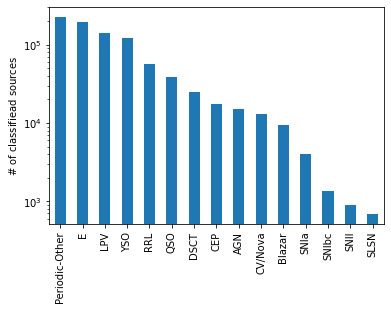

In [28]:
class_counts = Counter(class_final_name_ul)
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)

plt.yscale('log')
#plt.title('sources classified')
plt.ylabel(r'$\#$ of classifiead sources')

plt.savefig('plots/number_classified_sources.pdf',bbox_inches='tight')

0 SNIa 0.96
1 SNIbc 0.942
2 SNII 0.922
3 SLSN 0.808
4 QSO 0.99
5 AGN 0.922
6 Blazar 0.912
7 YSO 0.462
8 CV/Nova 0.456
9 LPV 0.778
10 E 0.944
11 DSCT 0.902
12 RRL 0.962
13 CEP 0.87
14 Periodic-Other 0.754


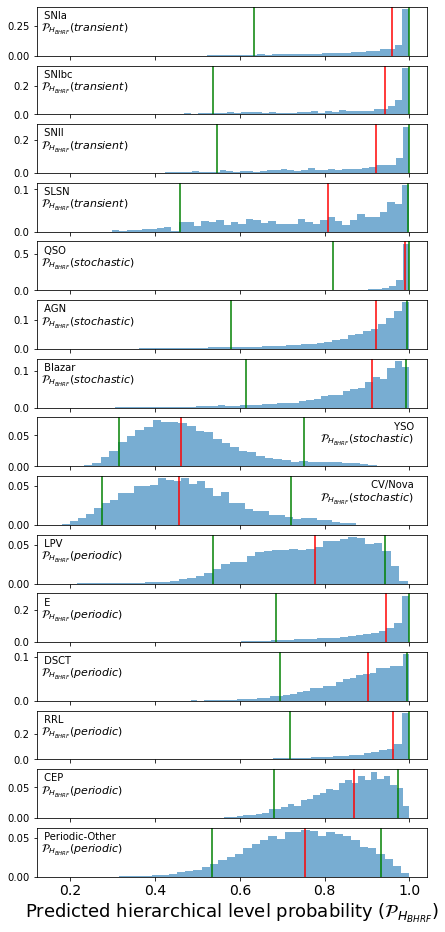

In [29]:
#plotting hierarchical level probabilities
fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(7, 16), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   if cl=="QSO" or cl=="AGN" or cl=='YSO' or cl=='CV/Nova' or cl=="Blazar":
        prob = 'prob_Stochastic'
   elif cl=="SNIa" or cl=="SNIbc" or cl=='SNII' or cl=='SLSN':
        prob = 'prob_Transient'
   else:      
        prob = 'prob_Periodic'
        
   print(idx, cl, np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   weights = np.ones_like(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values)/float(len(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values))
   nn,binsn,aux=ax[idx].hist(test_data_withclass[prob][test_data_withclass['predicted_class']==cl].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='stepfilled', bins=40, lw=5, label=cl, alpha=0.6)
   if (cl=="YSO") or (cl=="CV/Nova")  : 
       ax[idx].text(1.01, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='right')
   else: 
       ax[idx].text(0.13, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='left')
        
   if (cl=="LPV") or (cl=="CEP") or (cl=="RRL") or (cl=="DSCT") or (cl=="Periodic-Other") or (cl=="E") : 
        ax[idx].text(0.13, np.amax(nn)*0.40, "$\mathcal{P}_{H_{BHRF}}(periodic)$", fontsize=11, va='bottom', ha='left')


   elif (cl=="QSO") or (cl=="AGN") or (cl=="Blazar") : 
        ax[idx].text(0.13, np.amax(nn)*0.40, "$\mathcal{P}_{H_{BHRF}}(stochastic)$", fontsize=11, va='bottom', ha='left')

   elif (cl=="YSO") or (cl=="CV/Nova") : 
        ax[idx].text(1.01, np.amax(nn)*0.40, "$\mathcal{P}_{H_{BHRF}}(stochastic)$", fontsize=11, va='bottom', ha='right')



   else:
        ax[idx].text(0.13, np.amax(nn)*0.40, "$\mathcal{P}_{H_{BHRF}}(transient)$" , fontsize=11, va='bottom', ha='left')


        
plt.xticks(fontsize = 14)

ax[len(label_order)-1].set_xlabel(r'Predicted hierarchical level probability ($\mathcal{P}_{H_{BHRF}}$)',fontsize=18)
plt.savefig('plots/prob_dist_hierarchical_unlabeled_set.pdf',bbox_inches='tight')

0 SNIa 0.33786399999999994
1 SNIbc 0.31676400000000005
2 SNII 0.300768
3 SLSN 0.29516
4 QSO 0.73704
5 AGN 0.6240300000000001
6 Blazar 0.47525199999999995
7 YSO 0.38218
8 CV/Nova 0.26552
9 LPV 0.5818559999999999
10 E 0.443664
11 DSCT 0.346324
12 RRL 0.542376
13 CEP 0.327972
14 Periodic-Other 0.410256


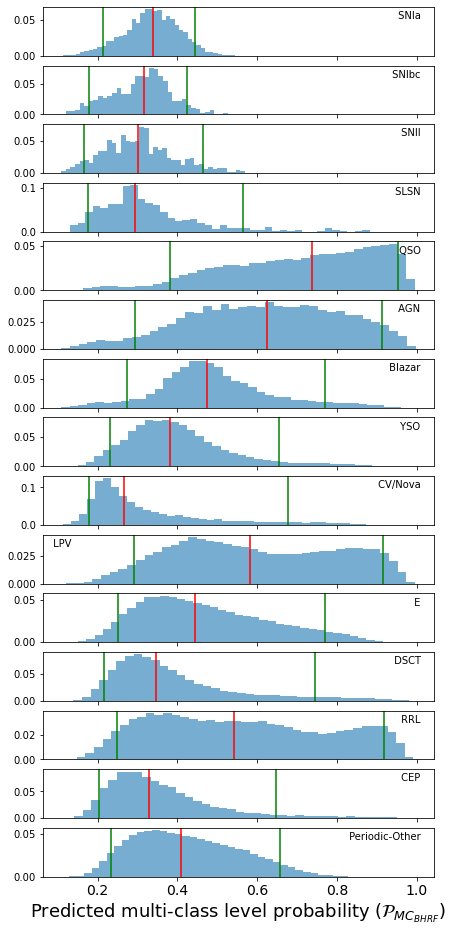

In [30]:
#plotting multi-class level probabilities

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(7, 16), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   weights = np.ones_like(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values)/float(len(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values))
   nn,binsn,aux=ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='stepfilled', bins=40, lw=5, label=cl, alpha=0.6)
   if (cl=="LPV"): 
       ax[idx].text(0.08, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='left')
   else: 
       ax[idx].text(1.01, np.amax(nn)*0.75, " %s" % (cl), fontsize=10, va='bottom', ha='right')

plt.xticks(fontsize = 14)

ax[len(label_order)-1].set_xlabel(r'Predicted multi-class level probability ($\mathcal{P}_{MC_{BHRF}}$)',fontsize=18)
plt.savefig('plots/prob_dist_unlabeled_set.pdf',bbox_inches='tight')

In [31]:
#for SN stats in paper
np.percentile(test_data_withclass['SLSN_prob'][test_data_withclass['predicted_class']=="SNII"].values, 50)


0.185744

[ 0.28745954  0.01148621 -0.00761852 ...  0.07376862  0.05683932
  0.24931978]


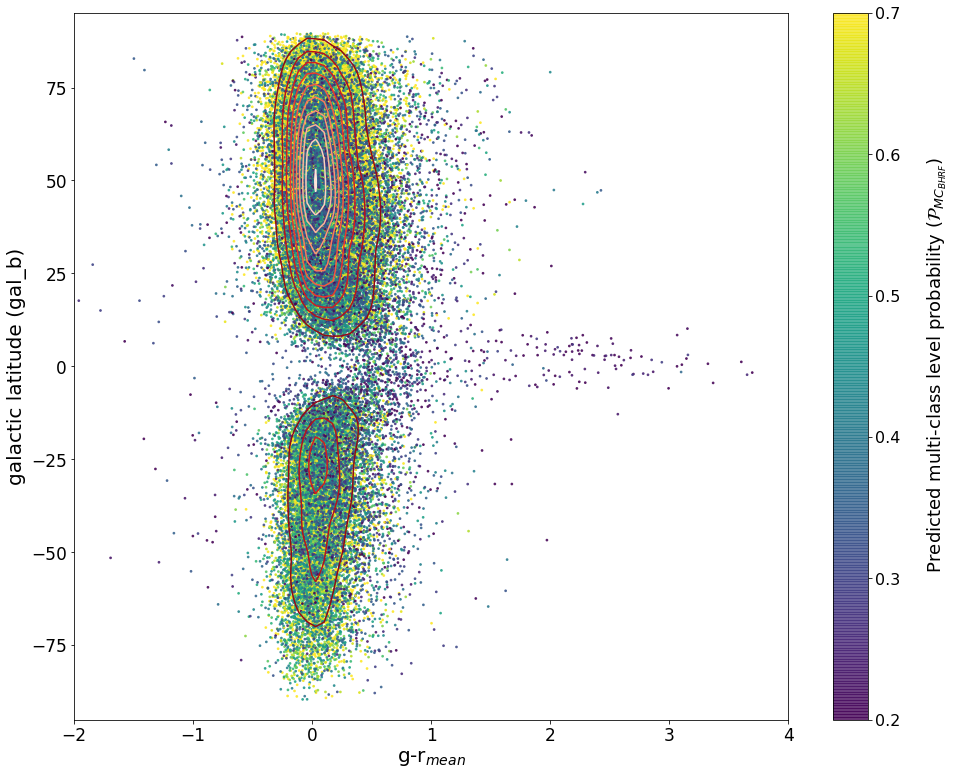

In [32]:
import matplotlib.cm as cm
import seaborn as sns

feature_x = 'g-r_mean'
feature_y = 'gal_b'
labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
color_list = []

for idx, cl in enumerate(labels_list):
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 3,label=cl)
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   color_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
    
gal_b_array = np.array(gal_b_list)
color_array = np.array(color_list)

print(color_array)

ax = sns.kdeplot(color_array,gal_b_array, n_levels=10, cmap="Reds_r", shade=False)
    
cbar = plt.colorbar(sc)
cbar.set_label('\n Predicted multi-class level probability ($\mathcal{P}_{MC_{BHRF}}$) ', rotation=90,fontsize=18)

#plt.legend(fontsize=15)
plt.xlabel(r'g-r$_{mean}$',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=16)

plt.savefig('plots/color_gal_b_selection_extragalactic.png',bbox_inches='tight',dpi=200)

[ 90.84914758 172.52388507  94.20044171 ... 243.78713087 147.90290087
 104.20778198]


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


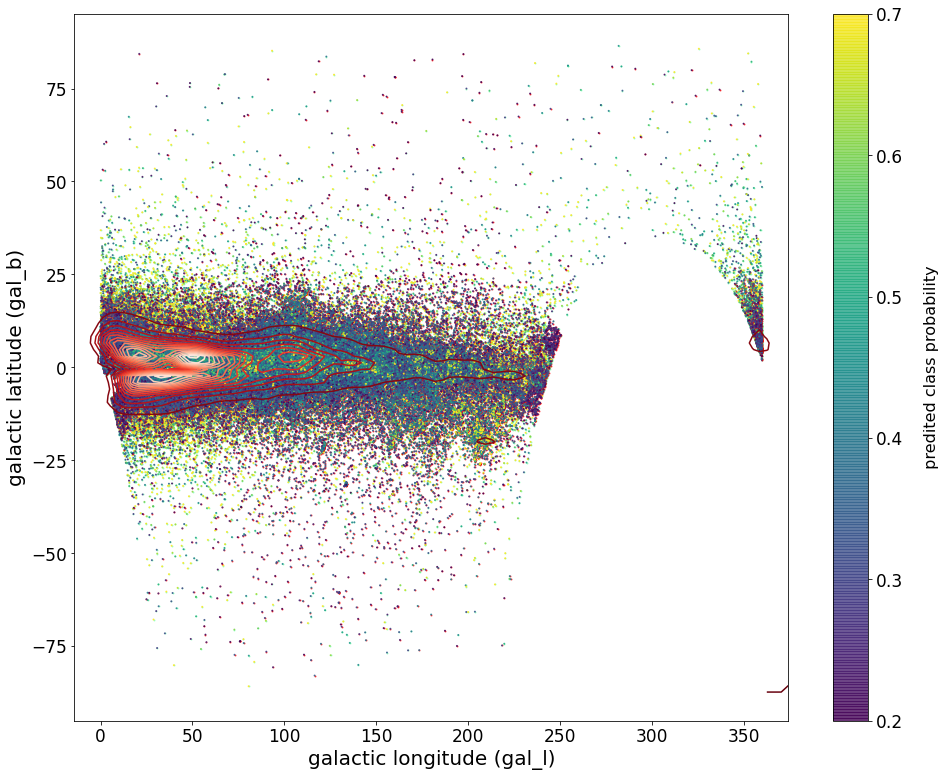

In [33]:
import matplotlib.cm as cm

feature_x = 'gal_l'
feature_y = 'gal_b'
labels_list = ['Ceph','LPV','YSO']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
#ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
gal_l_list = []


for idx, cl in enumerate(labels_list):
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 1,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 1,label=cl)
   ax.tick_params(labelsize=12)  
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   gal_l_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
   

gal_b_array = np.array(gal_b_list)
gal_l_array = np.array(gal_l_list)

print(gal_l_array)

ax = sns.kdeplot(gal_l_array,gal_b_array, n_levels=15, cmap="Reds_r", shade=False, linewidth = 0.05)


cbar = plt.colorbar(sc)
cbar.set_label('\n predited class probability ', rotation=90,fontsize=16)

#plt.legend(fontsize=15)
plt.xlabel(r'galactic longitude (gal_l)',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=17)
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.savefig('plots/gal_l_gal_b_selection_galactic.png',bbox_inches='tight',dpi=200)

[177.64783496 181.92578411 198.1811498  ... 121.96778866 237.72013552
 129.68462631]


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


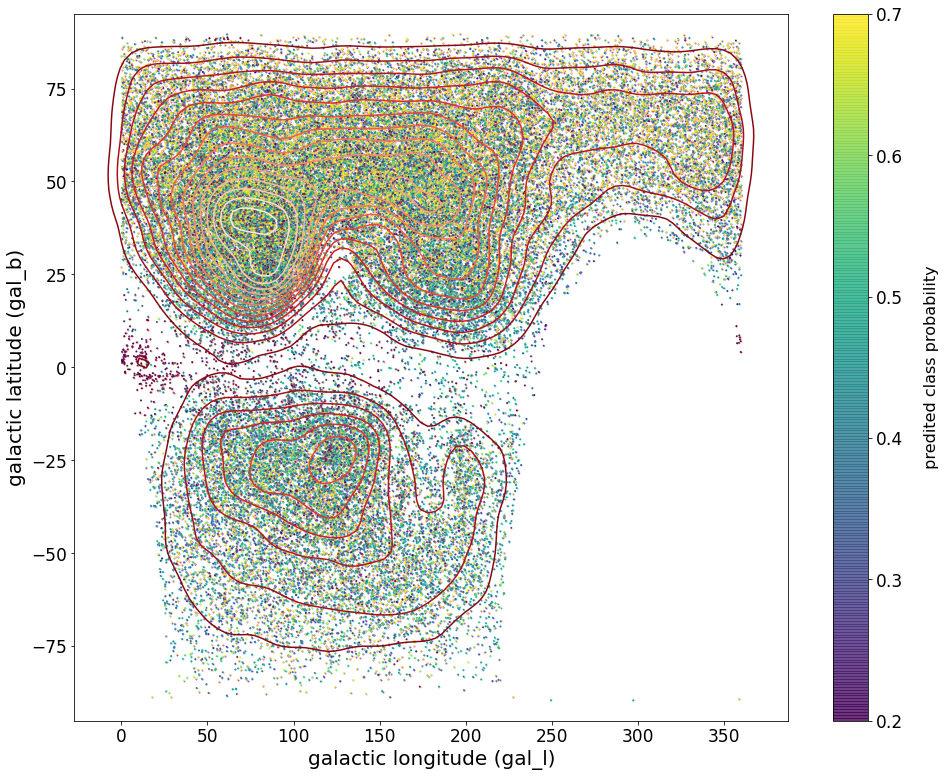

In [34]:
import matplotlib.cm as cm

feature_x = 'gal_l'
feature_y = 'gal_b'
labels_list = ['QSO','AGN','Blazar','SLSN','SNII','SNIa','SNIbc']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(16, 13))
#ax.set_xlim(-2,4)

cm = plt.cm.get_cmap('viridis')

gal_b_list = []
gal_l_list = []


for idx, cl in enumerate(labels_list):
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.65, s = 1,label=cl)
   sc = ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,c=df_test['predicted_class_proba'][df_test['predicted_class']==cl].values,vmin=0.2, vmax=0.7,cmap=cm,alpha = 0.8, s = 1,label=cl)
   ax.tick_params(labelsize=12)  
   gal_b_list+=list(df_test[feature_y][df_test['predicted_class']==cl].values)
   gal_l_list+=list(df_test[feature_x][df_test['predicted_class']==cl].values)
   

gal_b_array = np.array(gal_b_list)
gal_l_array = np.array(gal_l_list)

print(gal_l_array)

ax = sns.kdeplot(gal_l_array,gal_b_array, n_levels=15, cmap="Reds_r", shade=False, linewidth = 0.05)


cbar = plt.colorbar(sc)
cbar.set_label('\n predited class probability ', rotation=90,fontsize=16)

#plt.legend(fontsize=15)
plt.xlabel(r'galactic longitude (gal_l)',fontsize=20)
plt.ylabel(r'galactic latitude (gal_b)',fontsize=20) 

plt.gca().set_rasterized(True)
cbar.ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7],fontsize=17)
plt.ylim(-95,95)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

plt.savefig('plots/gal_l_gal_b_selection_extragalactic.png',bbox_inches='tight',dpi=200)

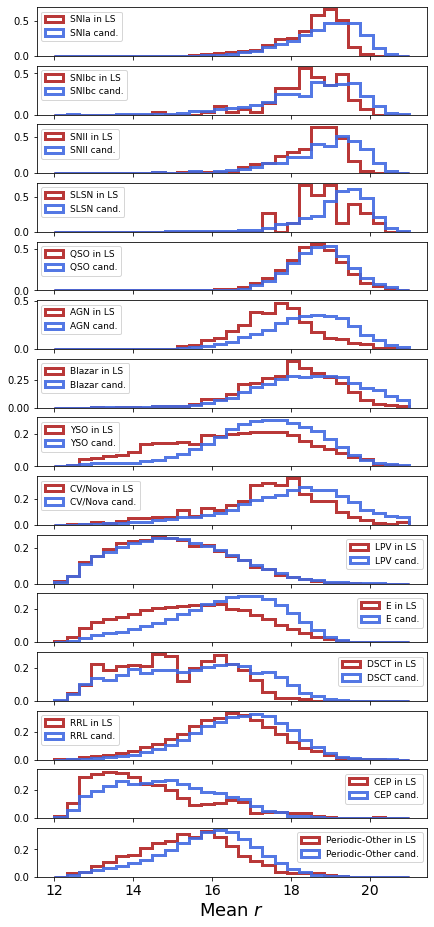

In [35]:
#magnitude distributions for labeled set and predictions in the unlabeled set
feature = 'Mean_2'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order),ncols=1, figsize=(7,16), sharex=True)


bins_hist = np.linspace(12,21,30)

for idx, cl in enumerate(label_order):
   
   if idx<=14:
       ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, cumulative=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label=cl+' in LS', alpha=0.9)
       ax[idx].hist(test_data_withclass[feature][test_data_withclass['predicted_class']==cl].values, cumulative=False, density=True, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label=cl+' cand.', alpha=0.9)
       
       if ((cl=="Periodic-Other") | (cl=="E") | (cl=="DSCT") | (cl=="CEP") | (cl=="LPV") ): ax[idx].legend(loc='upper right',fontsize=9)
        
       else: ax[idx].legend(loc='upper left',fontsize=9)
   
   else:
        break


ax[len(label_order)-1].set_xlabel(r'Mean $r$',fontsize=18)
plt.xticks(fontsize = 14)

plt.savefig('plots/Rband_magnitude_dist.pdf',bbox_inches='tight')

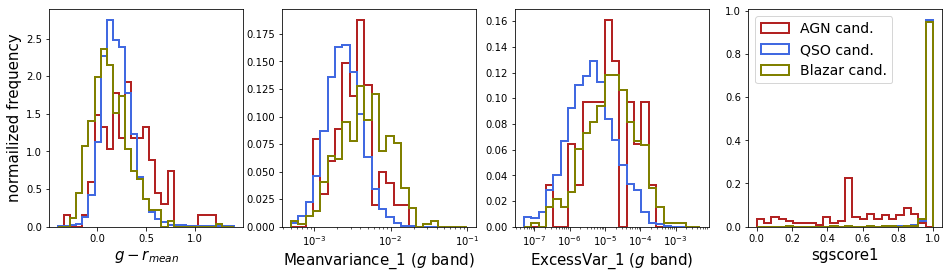

In [36]:
# for AGN analysis
df_for_figures = labels.join(test_data_withclass,how='left')


fig, ax = plt.subplots(nrows=1, ncols= 4, figsize = (16,4)) 


test_data_withclass


feature='g-r_mean_corr'
bins_hist = np.linspace(-0.4,1.4,30)#np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
ax[0].hist(df_for_figures[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
ax[0].hist(df_for_figures[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
ax[0].hist(df_for_figures[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, cumulative=False, stacked=False, density=True, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
#ax[0].legend(loc='upper right',fontsize=17)
ax[0].set_xlabel(r'$g-r_{mean}$',fontsize=15)
ax[0].set_ylabel(r'normailized frequency',fontsize=15)

feature='Meanvariance_1'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values))
ax[1].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values))
ax[1].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values))
ax[1].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
#ax[1].legend(loc='upper right',fontsize=17)
ax[1].set_xlabel(r'Meanvariance_1 ($g$ band)',fontsize=15)
#ax[1].set_ylabel(r'normailized frequency',fontsize=15)
ax[1].set_xscale('log')

feature='ExcessVar_1'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values))
ax[2].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values))
ax[2].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values))
ax[2].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
#ax[2].legend(loc='upper left',fontsize=17)
ax[2].set_xlabel(r'ExcessVar_1 ($g$ band)',fontsize=15)
#ax[2].set_ylabel(r'normailized frequency',fontsize=15)
ax[2].set_xscale('log')


feature='sgscore1'
bins_hist = np.linspace(0,1,25,endpoint=True)#np.logspace(np.log10(2e-4),np.log10(1500),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values))
ax[3].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='AGN')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values))
ax[3].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='QSO')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO cand.', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values)/float(len(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values))
ax[3].hist(df_for_figures_aux[feature][(df_for_figures['class_original']=='QSO') & (df_for_figures['predicted_class']=='Blazar')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar cand.', alpha=1.0)
ax[3].legend(loc='upper left',fontsize=14)
ax[3].set_xlabel(r'sgscore1',fontsize=15)
#ax[3].set_ylabel(r'normailized frequency',fontsize=15)



plt.savefig('plots/QSO_as_QSO_or_AGN.pdf',bbox_inches='tight')




In [37]:
np.percentile(test_data_withclass['SNII_prob'][test_data_withclass['predicted_class']=="SNII"].values, 50)



0.300768